In [2]:
!pip install numpyro
import jax
from jax import random
import jax.numpy as jnp
from jax import random
import numpyro
numpyro.enable_validation()
# ^ This allows numpyro to check e.g., if x is in the domain of a uniform dist.
# Since speed isn't a requirement for a tutorial, let's keep it on.
import numpyro.distributions as dist
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

import numpy as np
import random as rnd

from scipy.stats import gaussian_kde
import scipy.stats as stats
import math
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# adapts colours for theme
from google.colab import output
is_dark = output.eval_js('document.documentElement.matches("[theme=dark]")')

if(is_dark):
  prior_col = 'yellow'
  post_col = 'cyan'
  like_col = 'pink'
else:
  prior_col = 'purple'
  post_col = 'gray'
  like_col = 'teal'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 4.4 MB/s eta 0:00:00


In [ ]:
p = jnp.array(0.5)
bernoulli = dist.Bernoulli(probs=p)
rng = random.PRNGKey(42)

In [ ]:
sample = bernoulli.sample(key=rng)
print(sample)

1


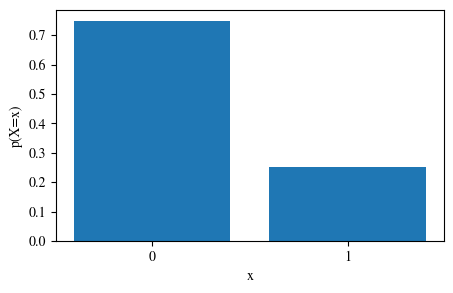

In [ ]:
#@title Bernoulli distribution interactive excercise { run: "auto" }
p = 0.23 #@param {type:"slider", min:0, max:1, step:0.01}

n = 1000
bernoulli_ = dist.Bernoulli(probs=p)
samples = bernoulli_.sample(key=rng, sample_shape=(n,))

num_ones = (samples == 1.).sum()
num_zeros = (samples == 0.).sum()

fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.bar([0, 1], [num_zeros/n, num_ones/n])
ax.set_xticks([0, 1])
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
plt.show()

In [ ]:
ps = jnp.array([0.1, 0.2, 0.3, 0.4])
categorical = dist.Categorical(probs=ps)
categorical

In [ ]:
samples = categorical.sample(key=rng, sample_shape=(10,))
print(samples)

[3 2 1 3 3 1 2 1 3 3]


In [ ]:
print(f"p(X=0) = {jnp.exp(categorical.log_prob(0)):.1f}")
print(f"p(X=1) = {jnp.exp(categorical.log_prob(1)):.1f}")
print(f"p(X=2) = {jnp.exp(categorical.log_prob(2)):.1f}")
print(f"p(X=3) = {jnp.exp(categorical.log_prob(3)):.1f}")

p(X=0) = 0.1
p(X=1) = 0.2
p(X=2) = 0.3
p(X=3) = 0.4


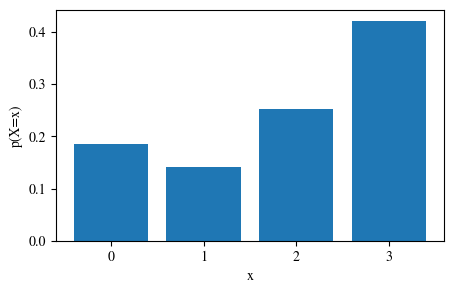

In [ ]:
#@title categorical distribution interactive excercise {run: "auto"}
l_0 = 0.7 #@param {type:"slider", max:4, step:0.1}
l_1 = 0.5 #@param {type:"slider", max:4, step:0.1}
l_2 = 1 #@param {type:"slider", max:4, step:0.1}
l_3 = 1.6 #@param {type:"slider", max:4, step:0.1}

logits = jnp.array([l_0, l_1, l_2, l_3], dtype=jnp.float32)
categorical = dist.Categorical(logits=logits)
samples = categorical.sample(key=rng, sample_shape=(1000,))

values =[0, 1, 2, 3]
hist, _ = jnp.histogram(
    samples, bins=jnp.array(values + [4]), density=True
)

fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.bar(values, hist)
ax.set_xticks(values)
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
plt.show()


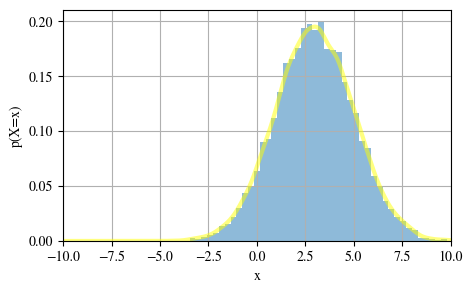

In [ ]:
#@title normal distribution interactive excercise {run: "auto"}
μ = 3 #@param {type:"slider", min:-5, max:5, step:0.1}
σ = 2 #@param {type:"slider", max:4, step:0.1}

normal = dist.Normal(loc=μ, scale=σ)
samples = normal.sample(key=rng, sample_shape=(10000,))

fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.hist(samples, bins=50, density=True, alpha=0.5)
x = jnp.linspace(-10, 10, 3000)
kde = gaussian_kde(samples)
ax.plot(x, kde(x), color='yellow', lw=3, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
ax.set_xlim(-10, 10)
ax.grid(0.3)
plt.show()

In [ ]:


#@title Implementing the normal PDF from scratch!
#@markdown **code task 1:** Let's implement the PDF for the normal distribution from scratch, just using functions from `jax`.
#@markdown *Hint:* You may want to use `jnp.pi`, `jnp.sqrt`, and `jnp.exp`.

def normal_pdf(loc, scale, x):
    p_x = 1 / jnp.sqrt(2 * jnp.pi * scale**2)
    p_x *= jnp.exp(-((loc - x)**2) / (2 * scale**2))

    return p_x



In [ ]:
# @title Run me to test your code
def test_normal_pdf(pdf_fn):
  assert pdf_fn(0, 1, 0) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(0)), "Normal(X=0|0, 1) is incorrect."
  assert pdf_fn(0, 2, 0) == jnp.exp(dist.Normal(loc=0, scale=2).log_prob(0)), "Normal(X=0|0, 2) is incorrect."
  assert pdf_fn(0, 1, 1) == jnp.exp(dist.Normal(loc=0, scale=1).log_prob(1)), "Normal(X=0|1, 1) is incorrect."
  assert pdf_fn(2, 3, 1) == jnp.exp(dist.Normal(loc=2, scale=3).log_prob(1)), "Normal(X=1|2, 3) is incorrect."
  print("Nice! Your answer looks correct.")

test_normal_pdf(normal_pdf)


Nice! Your answer looks correct.


In [ ]:
#@title Expected value interactive excercise {run: "auto"}
N = 200 #@param {type:"slider", min:1, max:400, step:1}
μ = 0 #@param {type:"slider", min:-5, max:5, step:0.1}
σ = 4 #@param {type:"slider", min: 0.1, max:4, step:0.1}

normal = dist.Normal(loc=μ, scale=σ)
samples = normal.sample(key=rng, sample_shape=(N,))

expected_value = jnp.sum(samples) / N

print(f'E[X] = {expected_value:.5f}')


E[X] = 0.51140


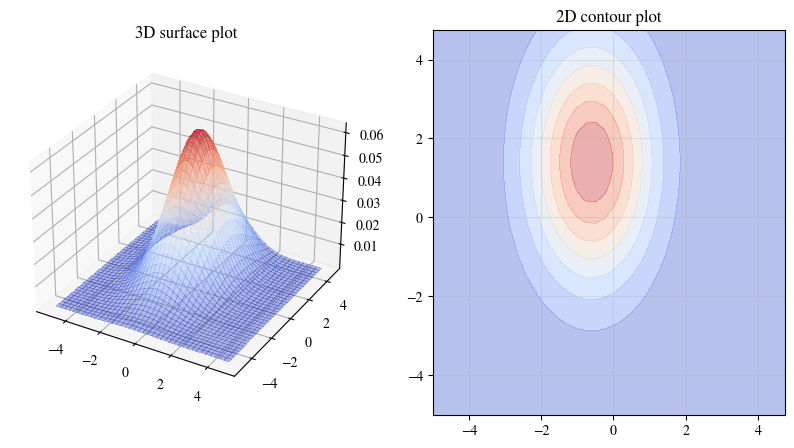

In [ ]:
#@title Multivariate normal interactive excercise 1 {run: "auto"}

#@markdown Both plots below show the same 2D normal distribution. Each plot is useful for visualizing the distribution in different ways.

#@markdown The plot on the left helps us visualise the probability values for each pair.

#@markdown The plot on the right helps us visualise the shape of the distribution from above. Note that the colors represent the same probabilities as the left-hand plot. Each ring shows pairs of equal probability.

from matplotlib import gridspec
from scipy.stats import norm

μ1 = -0.6 #@param {type:"slider", min:-5, max:5, step:0.1}
σ1 = 1.2 #@param {type:"slider", min: 0.1, max:4, step:0.1}
μ2 = 1.4 #@param {type:"slider", min:-5, max:5, step:0.1}
σ2 = 2.1 #@param {type:"slider", min: 0.1, max:4, step:0.1}
ρ = 0 #@param {type:"slider", min: -1, max:1, step:0.1}

μ = jnp.array([μ1, μ2])
Σ = jnp.array([[σ1**2, ρ*σ1*σ2],[ρ*σ2*σ1, σ2**2]])

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121, projection='3d')

X1 = jnp.arange(-5, 5, 0.25)
X2 = jnp.arange(-5, 5, 0.25)
X1, X2 = jnp.meshgrid(X1, X2)
Xs = jnp.concatenate(
    [X1.reshape(-1, 1), X2.reshape(-1, 1)], axis=1
)
Z = jax.vmap(
    lambda x: jnp.exp(dist.MultivariateNormal(μ, Σ).log_prob(x))
)(Xs).reshape(X1.shape)

from matplotlib import cm
ax1.plot_surface(X1, X2, Z, cmap=cm.coolwarm,
                linewidth=0, alpha=0.4, antialiased=False)
ax1.set_title('3D surface plot')


ax2 = fig.add_subplot(122)
ax2.contourf(X1, X2, Z, cmap=cm.coolwarm,
            alpha=0.4, antialiased=False)
ax2.set_title('2D contour plot')


ax2.grid(alpha=0.3)
plt.show()

In [ ]:
#@title Multivariate normal interactive excercise 2 {run: "auto"}

from matplotlib import gridspec
from scipy.stats import norm

μ1 = 0.7 #@param {type:"slider", min:-5, max:5, step:0.1}
σ1 = 1.8 #@param {type:"slider", min: 0.1, max:4, step:0.1}
μ2 = 1.6 #@param {type:"slider", min:-5, max:5, step:0.1}
σ2 = 1 #@param {type:"slider", min: 0.1, max:4, step:0.1}
ρ = 0.529 #@param {type:"slider", min: -0.999, max:0.999, step:0.001}
x1 = -0.4 #@param {type:"slider", min:-5, max:5, step:0.1}
x2 = 2.2 #@param {type:"slider", min:-5, max:5, step:0.1}

μ = jnp.array([μ1, μ2])
Σ = jnp.array([[σ1**2, ρ*σ1*σ2],[ρ*σ2*σ1, σ2**2]])

cond_μ_x1, cond_σ_x1 = Gaussian_conditional(μ, Σ, x=None, y=x2)
cond_μ_x2, cond_σ_x2 = Gaussian_conditional(μ, Σ, x=x1, y=None)

xrange = jnp.linspace(-10, 10, 300)
density_x1 = norm.pdf(xrange, μ1, σ1)
density_x2 = norm.pdf(xrange, μ2, σ2)

cond_density_x1 = norm.pdf(xrange, cond_μ_x1, cond_σ_x1)
cond_density_x2 = norm.pdf(xrange, cond_μ_x2, cond_σ_x2)

plt.figure(dpi=140)
gs = gridspec.GridSpec(2, 2, width_ratios=[1,3], height_ratios=[3,1])
ax = plt.subplot(gs[0,1])
axl = plt.subplot(gs[0,0], sharey=ax)
axb = plt.subplot(gs[1,1], sharex=ax)

plot_log_gaussian_ellipse(ax, μ, Σ, color='C0', alpha=1, lw=1, label=None, MAP_size=5, std_levels=[0.7, 1.5, 2.3])
ax.set_title('joint distribution')
ax.axvline(x1, lw=1, c='C1')
ax.axhline(x2, lw=1, c='C2')

axb.plot(xrange, density_x1, c='C0', lw=1, label='marginal')
axb.plot(xrange, cond_density_x1, '--', c='C2', lw=1, label=f'conditional $p(X_1=x_1 | X_2={x2})$')
axb.set_xlabel('')
axb.set_xlim([-3,4])
axb.legend(bbox_to_anchor=[0.5, -1.1],loc='center')

axl.plot(density_x2, xrange, c='C0', lw=1, label='marginal')
axl.plot(cond_density_x2, xrange, '--', c='C1', lw=1, label=f'conditional $p(X_2 = x_2 | X_1={x1})$')
axl.set_ylabel('')
axl.set_ylim([-1.5,7.5])
axl.invert_xaxis()
axl.legend(bbox_to_anchor=[-0.15, -0.3],loc='center')
ax.grid(alpha=0.3)
axl.grid(alpha=0.3)
axb.grid(alpha=0.3)
plt.show()

AttributeError: module 'jax.numpy' has no attribute 'Gaussian_conditional'

In [ ]:
values = jnp.array([1., 2.])
normal = dist.Normal(0., 1.)
print(f"event_shape = {normal.event_shape}")
print(f"batch_shape = {normal.batch_shape}")
print(f"p(X = {values}) = {jnp.exp(normal.log_prob(values))}")

event_shape = ()
batch_shape = ()
p(X = [1. 2.]) = [0.24197073 0.05399096]


In [ ]:
batch_normal = dist.Normal(jnp.array([0., 1.]), jnp.array([1., 2.]))
print(f"event_shape = {batch_normal.event_shape}")
print(f"batch_shape = {batch_normal.batch_shape}")
print(f"[p(X_1 = {values[0]}), p(X_2 = {values[1]})] = {jnp.exp(batch_normal.log_prob(values))}")
print(f"p(X_1 = {values[0]}, X_2 = {values[1]}) = {jnp.prod(jnp.exp(batch_normal.log_prob(values)))}")

event_shape = ()
batch_shape = (2,)
[p(X_1 = 1.0), p(X_2 = 2.0)] = [0.24197073 0.17603266]
p(X_1 = 1.0, X_2 = 2.0) = 0.042594753205776215


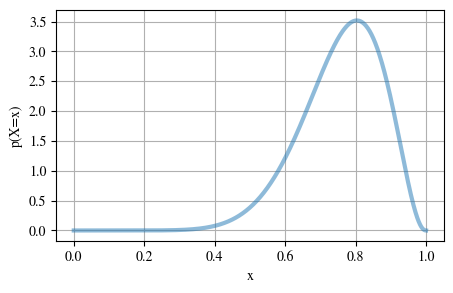

In [ ]:
#@title beta distribution interactive excercise {run: "auto"}
α = 10 #@param {type:"slider", min:0.1, max:10, step:0.1}
β = 3.2 #@param {type:"slider", min:0.1, max:10, step:0.1}

beta = dist.Beta(α, β)
xs = jnp.linspace(0, 1, 1000)

fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(xs, jnp.exp(beta.log_prob(xs)), color='C0', lw=3, alpha=0.5)
ax.set_xlabel('x')
ax.set_ylabel('p(X=x)')
ax.grid(0.3)
plt.show()

In [ ]:
def kl_divergence(p: dist.Distribution, q: dist.Distribution, n: int = 10_000):
    xs = p.sample(rng, sample_shape = (n,))
    p_log_probs = p.log_prob(xs)
    q_log_probs = q.log_prob(xs)

    return -(q_log_probs - p_log_probs).mean()


In [ ]:
print(kl_divergence(dist.Uniform(0,1),dist.Beta(5,2),10000))
print(kl_divergence(dist.Uniform(0,1),dist.Beta(2,2),10000))
print(kl_divergence(dist.Uniform(0,1),dist.Beta(1,1),10000))
print(kl_divergence(dist.Beta(5,2),dist.Uniform(0,1),10000))

1.6500689
0.22074455
9.536743e-07
0.48455995


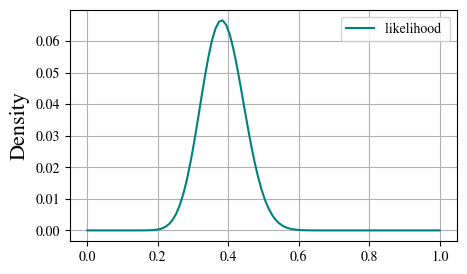

In [ ]:
# @title ##MLE interactive task  {run: "auto"}

##############################################
# coin tossing
# n number of tosses
# p_H proportion of heads
# h number of heads (this is set by p and n)
##############################################

# define grid
grid_points=100

# define regular grid in the (0,1) interval
p_grid = jnp.linspace(0, 1, grid_points)

n = 63 #@param {type:"slider", min:1, max:100, step:1}
h = 24 #@param {type:"slider", min:0, max:100, step:1}


# compute likelihood at each point in the grid
log_prob_likelihood = dist.Binomial(n, probs=p_grid).log_prob(h)

# normalize likelihood to get the likelihood PMF
likelihood = jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)) / jnp.sum(jnp.exp(log_prob_likelihood - jnp.max(log_prob_likelihood)))

fig = plt.figure(dpi=100, figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(p_grid, likelihood,color='teal',label='likelihood ')
ax.legend()
ax.set_xlabel('', fontsize=14)
ax.set_ylabel('Density', fontsize=16)
ax.grid(0.3)
plt.show()

1.7182817
        10 1.902797
       100 1.794066
      1000 1.712517
     10000 1.725022
    100000 1.718987
   1000000 1.719357
  10000000 1.718302
 100000000 1.718358


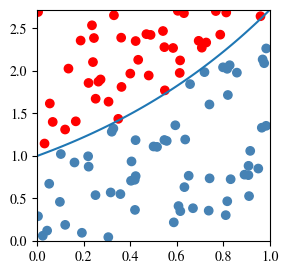

In [3]:
#@title Monte Carlo integration code
print(jnp.exp(1) - jnp.exp(0))

plt.figure(figsize=(3, 3))

x = jnp.linspace(0, 1, 100)
plt.plot(x, jnp.exp(x));
pts = np.random.uniform(0,1,(100, 2))
pts[:, 1] *= jnp.e

cols = ['steelblue'] * 100
for i in range(100):
    if pts[i,1] > jnp.exp(pts[i,0]):     # acceptance / rejection step
        cols[i] = 'red'


plt.scatter(pts[:, 0], pts[:, 1], c = cols)
plt.xlim([0,1])
plt.ylim([0, jnp.e]);

# Monte Carlo approximation

for n in 10**np.array([1, 2, 3, 4, 5, 6, 7, 8]):
    pts = np.random.uniform(0, 1, (n, 2))
    pts[:, 1] *= jnp.e
    count = jnp.sum(pts[:, 1] < jnp.exp(pts[:, 0]))
    volume = jnp.e * 1 # volume of region
    sol = (volume * count)/n
    print('%10d %.6f' % (n, sol))